In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import random
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
import tensorflow as tf
import pandas as pd
from utils import *
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.datasets import imdb
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Embedding, RNN, LSTM, Bidirectional
from tensorflow import keras
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

found yoochoose cache
max possible session length: 262


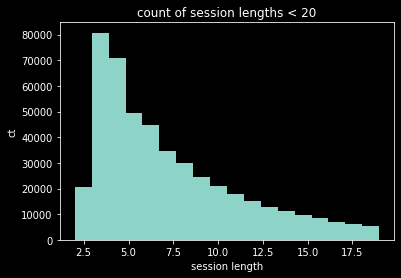

max_embedding_key: 52738 max_session_len: 8
[[50608 27403  9573 46253  4934 51523  9275 48341]
 [ 6782  2565  6782  6782     0     0     0     0]
 [ 2989  1450  2989 34813 34817     0     0     0]
 [48739  5220 51581 32799 31834 40884 45318 16682]
 [46930  3228  3228 46908 20335 46916 47474  3228]
 [20136 29591 17019 14824  8528 36819 21781 40926]
 [39838 16810 23626 51993 38510 30847  2169 13311]
 [49179   258   258     0     0     0     0     0]
 [33609 13025 24666  6313 39044  6573   588  4299]
 [33047 33047 33047     0     0     0     0     0]]
[0 1 1 0 1 0 0 1 0 1]


In [2]:
dataset, unpadded_dataset, column_names, keymap = load_yoochoose_dataset(reinitialize=False)
num_sessions = len(dataset)

print(f"max possible session length: {max([len(session) for session in unpadded_dataset])}")

plt.hist([len(session) for session in unpadded_dataset if len(session) < 20], bins=18)
plt.xlabel("session length")
plt.ylabel("ct")
plt.title("count of session lengths < 20")
plt.show()

max_embedding_key = len(keymap)-1
max_session_len = max([len(i) for i in dataset])
print(f"max_embedding_key: {max_embedding_key} max_session_len: {max_session_len}")

train, val, test = train_val_test_split(dataset)

x_train = np.array(list(train))[0, :, :, 0]
y_train = np.ones(len(x_train))

fake_x_train = np.random.randint(0, max_embedding_key, size=x_train.shape, dtype=np.uint32)
fake_y_train = np.zeros(len(x_train))

x_train_p = np.concatenate((x_train, fake_x_train))
y_train_p = np.concatenate((y_train, fake_y_train))

train_indices = list(range(len(x_train_p)))
random.shuffle(train_indices)
x_train_p = x_train_p[train_indices]
y_train_p = y_train_p[train_indices]

x_val = np.array(list(val))[0, :, :, 0]
y_val = np.ones(len(x_val))

fake_x_val = np.random.randint(0, max_embedding_key, size=x_val.shape, dtype=np.uint32)
fake_y_val = np.zeros(len(x_val))

x_val_p = np.concatenate((x_val, fake_x_val))
y_val_p = np.concatenate((y_val, fake_y_val))

val_indices = list(range(len(x_val_p)))
random.shuffle(val_indices)
x_val_p = x_val_p[val_indices]
y_val_p = y_val_p[val_indices]


print(x_train_p[:10])
print(y_train_p[:10])

In [3]:
for x, y in zip(x_train_p[:50], y_train_p[:50]):
    print(x, y)

[50608 27403  9573 46253  4934 51523  9275 48341] 0.0
[6782 2565 6782 6782    0    0    0    0] 1.0
[ 2989  1450  2989 34813 34817     0     0     0] 1.0
[48739  5220 51581 32799 31834 40884 45318 16682] 0.0
[46930  3228  3228 46908 20335 46916 47474  3228] 1.0
[20136 29591 17019 14824  8528 36819 21781 40926] 0.0
[39838 16810 23626 51993 38510 30847  2169 13311] 0.0
[49179   258   258     0     0     0     0     0] 1.0
[33609 13025 24666  6313 39044  6573   588  4299] 0.0
[33047 33047 33047     0     0     0     0     0] 1.0
[41269 21301   695  8300 41575 33795 33662 15633] 0.0
[37076 52279 36128 11299 32537 10341 19798 12295] 0.0
[25730 11554 40301 23197 15223  5286 17138 22670] 0.0
[46312 37915 46312  8191 46312 37915     0     0] 1.0
[1346   48   49    7   49 4034 4034   54] 1.0
[50097 20769 15619 17051  7711 14482 30663 29366] 0.0
[51079 51131 51131 51099 51121 51131     0     0] 1.0
[49408 49242 21744 34988 22735 25955 15109 49408] 1.0
[21315 23588 47404 30463 18871 14079 26779 3

In [ ]:
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

class IdkModel(Model):
    def __init__(self):
        super(IdkModel, self).__init__()
        self.embedding_layer = Embedding(max_embedding_key, 128, input_length=max_session_len)
        self.encoder = Bidirectional(LSTM(64, return_sequences=False, return_state=False, unroll=False), merge_mode="concat")
        self.final_dense_layer = Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros')
        self.sigmoid_layer = Dense(max_embedding_key, kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='softmax')

    def build_item_attention(self):
        self.item_attention_W = 

    def call(self, x):
        encoder_output = self.encoder(self.embedding_layer(x))
        return self.sigmoid_layer(self.final_dense_layer(encoder_output))

# @tf.function
# def train_step(images, labels):
#     with tf.GradientTape() as tape:
#         # training=True is only needed if there are layers with different
#         # behavior during training versus inference (e.g. Dropout).
#         predictions = model(images, training=True)
#         loss = loss_object(labels, predictions)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#     train_loss(loss)
#     train_accuracy(labels, predictions)

# @tf.function
# def test_step(images, labels):
#     # training=False is only needed if there are layers with different
#     # behavior during training versus inference (e.g. Dropout).
#     predictions = model(images, training=False)
#     t_loss = loss_object(labels, predictions)

#     test_loss(t_loss)
#     test_accuracy(labels, predictions)

# EPOCHS = 5

# for epoch in range(EPOCHS):
# # Reset the metrics at the start of the next epoch
#     train_loss.reset_states()
#     train_accuracy.reset_states()
#     test_loss.reset_states()
#     test_accuracy.reset_states()

#     for batch_docs, batch_labels in data_reader.read_train_set(1000, shuffle=True):
#         train_step(batch_docs, batch_labels)

#     for test_images, test_labels in test_ds:
#         test_step(test_images, test_labels)

#     template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
#     print(template.format(epoch+1,
#         train_loss.result(),
#         train_accuracy.result()*100,
#         test_loss.result(),
#         test_accuracy.result()*100))


# config = tf.ConfigProto(allow_soft_placement=FLAGS.allow_soft_placement)
# with tf.Session() as sess:
#     model = Model(cell_dim=FLAGS.cell_dim,
#                 att_dim=FLAGS.att_dim,
#                 vocab_size=len(vocab),
#                 emb_size=FLAGS.emb_size,
#                 num_classes=FLAGS.num_classes,
#                 dropout_rate=FLAGS.dropout_rate,
#                 pretrained_embs=glove_embs)

#     loss = loss_fn(model.labels, model.logits)
#     train_op, global_step = train_fn(loss)
#     batch_acc, total_acc, acc_update, metrics_init = eval_fn(model.labels, model.logits)
#     summary_op = tf.summary.merge_all()
#     sess.run(tf.global_variables_initializer())

#     train_writer.add_graph(sess.graph)
#     saver = tf.train.Saver(max_to_keep=FLAGS.num_checkpoints)

#     print('\n{}> Start training'.format(datetime.now()))

#     epoch = 0
#     valid_step = 0
#     test_step = 0
#     train_test_prop = len(data_reader.train_data) / len(data_reader.test_data)
#     test_batch_size = int(FLAGS.batch_size / train_test_prop)
#     best_acc = float('-inf')

#     while epoch < FLAGS.num_epochs:
#         epoch += 1
#         print('\n{}> Epoch: {}'.format(datetime.now(), epoch))

#         sess.run(metrics_init)
#         for batch_docs, batch_labels in data_reader.read_train_set(FLAGS.batch_size, shuffle=True):
#             _step, _, _loss, _acc, _ = sess.run([global_step, train_op, loss, batch_acc, acc_update],
#                                                                              feed_dict=model.get_feed_dict(batch_docs, batch_labels, training=True))
#             if _step % FLAGS.display_step == 0:
#                 _summary = sess.run(summary_op, feed_dict=model.get_feed_dict(batch_docs, batch_labels))
#                 train_writer.add_summary(_summary, global_step=_step)
#         print('Training accuracy = {:.2f}'.format(sess.run(total_acc) * 100))

#         sess.run(metrics_init)
        # for batch_docs, batch_labels in data_reader.read_valid_set(test_batch_size):
#             _loss, _acc, _  = sess.run([loss, batch_acc, acc_update], feed_dict=model.get_feed_dict(batch_docs, batch_labels))
#             valid_step += 1
#             if valid_step % FLAGS.display_step == 0:
#                 _summary = sess.run(summary_op, feed_dict=model.get_feed_dict(batch_docs, batch_labels))
#                 valid_writer.add_summary(_summary, global_step=valid_step)
#         print('Validation accuracy = {:.2f}'.format(sess.run(total_acc) * 100))

#         sess.run(metrics_init)
#         for batch_docs, batch_labels in data_reader.read_test_set(test_batch_size):
#             _loss, _acc, _  = sess.run([loss, batch_acc, acc_update], feed_dict=model.get_feed_dict(batch_docs, batch_labels))
#             test_step += 1
#             if test_step % FLAGS.display_step == 0:
#                 _summary = sess.run(summary_op, feed_dict=model.get_feed_dict(batch_docs, batch_labels))
#                 test_writer.add_summary(_summary, global_step=test_step)
#         test_acc = sess.run(total_acc) * 100
#         print('Testing accuracy = {:.2f}'.format(test_acc))

#         if test_acc > best_acc:
#             best_acc = test_acc
#             saver.save(sess, FLAGS.checkpoint_dir)
#         print('Best testing accuracy = {:.2f}'.format(test_acc))

# print("{} Optimization Finished!".format(datetime.now()))
# print('Best testing accuracy = {:.2f}'.format(best_acc))


In [6]:
batch_size = 64

# x_train = np.array(list(train))[0, :, :, 0]
# y_train = np.ones(len(x_train))

# fake_x_train = np.random.randint(0, max_embedding_key, size=x_train.shape, dtype=np.uint32)
# fake_y_train = np.zeros(len(x_train))


model = IdkModel()

model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train_p, y_train_p, batch_size=64, epochs=4, validation_data=[x_val, y_val])


# x_train_p = np.concatenate((x_train, fake_x_train))
# y_train_p = np.concatenate((y_train, fake_y_train))

# x_val = np.array(list(val))[0, :, :, 0]
# y_val = np.ones(len(x_val))


Train on 652410 samples, validate on 81551 samples
Epoch 1/4
652410/652410 [==============================] - 516s 791us/sample - loss: 0.0829 - accuracy: 0.9792 - val_loss: 0.0215 - val_accuracy: 0.9928
Epoch 2/4
652410/652410 [==============================] - 512s 784us/sample - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.0367 - val_accuracy: 0.9915
Epoch 3/4
652410/652410 [==============================] - 510s 782us/sample - loss: 7.7947e-04 - accuracy: 0.9998 - val_loss: 0.0488 - val_accuracy: 0.9932
Epoch 4/4
652410/652410 [==============================] - 514s 788us/sample - loss: 8.4637e-05 - accuracy: 1.0000 - val_loss: 0.0728 - val_accuracy: 0.9934


In [ ]:
# with tf.Session() as sess:
#     y_true = tf.placeholder(dtype=tf.float64, shape=[None, 1])

#     learning_rate=.001
#     epochs=60
#     ce_loss_term = -(tf.reduce_mean(((y_true+1)/2)*tf.math.log((pred_y+1)/2)+(1-(y_true+1)/2)*tf.math.log(1-(pred_y+1)/2)))
#     train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(ce_loss_term)

#     sess.run(tf.global_variables_initializer())

#     for epoch in tqdm(range(epochs), leave=False):
#         print("epoch", epoch)
#         print("training")
#         for b_Xs, b_ys in batchify(train_Xs, train_ys, batch_size=746661):
#             session_idxs, item_idxs = b_Xs.T
#             feed_dict = {session_slice_idxs: session_idxs, 
#                         item_slice_idxs: item_idxs, 
#                         y_true: b_ys}
#             outs = (train_step, ce_loss_term, pred_y)
#             _, loss_val, pred_y_val = sess.run(outs, feed_dict=feed_dict)
#             print("pred_ys", pred_y_val, "true_ys", b_ys[:5])



In [13]:
from tqdm import tqdm

batch_size = 128

# model.fit(x_train_p, y_train_p, batch_size=batch_size, epochs=4, validation_data=[x_val, y_val])

# row_id_to_idx = {k: v for v, k in enumerate(set(clicks_df["sessionId"])|set(buys_df["sessionId"]))}
# col_id_to_idx = {k: v for v, k in enumerate(set(clicks_df["itemId"])|set(buys_df["itemId"]))}

# matrix_shape = (len(row_id_to_idx), len(col_id_to_idx))

# row_indices = [row_id_to_idx[row_id] for row_id in clicks_df["sessionId"]]
# col_indices = [col_id_to_idx[col_id] for col_id in clicks_df["itemId"]]
# elements = np.ones(len(col_indices), dtype=np.int8)
# viewed_matrix = csr_matrix((elements, (row_indices, col_indices)), shape=matrix_shape)

# row_indices = [row_id_to_idx[row_id] for row_id in buys_df["sessionId"]]
# col_indices = [col_id_to_idx[col_id] for col_id in buys_df["itemId"]]
# elements = np.ones(len(col_indices), dtype=np.int8)
# buys_matrix = csr_matrix((elements, (row_indices, col_indices)), shape=matrix_shape)

# interaction_matrix = 2*buys_matrix-viewed_matrix
model = IdkModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


@tf.function
def train_step(sessions, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(sessions, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(sessions, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(sessions, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


EPOCHS = 5
num_x = len(x_train_p)

for epoch in range(EPOCHS):
    print(f"epoch {epoch}/{EPOCHS}")
# Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for i, (batch_sess, batch_labels) in enumerate(list(batchify(x_train_p, y_train_p, batch_size=batch_size))):
        train_step(batch_sess, batch_labels)
        if i % 10 == 0:
            tf.print(f"{i*batch_size}/{num_x}", train_accuracy.result())

    for i, (batch_sess, batch_labels) in enumerate(list(batchify(x_val_p, y_val_p, batch_size=batch_size))):
        test_step(batch_sess, batch_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
        train_loss.result(),
        train_accuracy.result()*100,
        test_loss.result(),
        test_accuracy.result()*100))


93426859
317440/652410 0.993437648
318720/652410 0.993426323
320000/652410 0.993424535
321280/652410 0.993441343
322560/652410 0.993439496
323840/652410 0.993434548
325120/652410 0.99343884
326400/652410 0.993433952
327680/652410 0.993435204
328960/652410 0.993421197
330240/652410 0.993413389
331520/652410 0.99340266
332800/652410 0.993407
334080/652410 0.993396342
335360/652410 0.993379772
336640/652410 0.993378222
337920/652410 0.993385553
339200/652410 0.993386924
340480/652410 0.993397117
341760/652410 0.993398428
343040/652410 0.993399739
344320/652410 0.993401051
345600/652410 0.993387878
346880/652410 0.993383467
348160/652410 0.993379056
349440/652410 0.993371844
350720/652410 0.993373215
352000/652410 0.993380249
353280/652410 0.99338156
354560/652410 0.993377268
355840/652410 0.993395448
357120/652410 0.993393958
358400/652410 0.993386865
359680/652410 0.993371487
360960/652410 0.993364513
362240/652410 0.993352056
363520/652410 0.993337
364800/652410 0.993346632
366080/65241

In [35]:
print(x_train[:10])

model.predict(np.array([[42449, 42446, 42436, 42335, 42461, 42449, 42436, 42335]], dtype=np.uint32))


# plt.hist(np.sum(interaction_matrix, axis=1), log=True, bins=300)
# plt.xlabel("item views per session")
# plt.ylabel("count")
# plt.show()

[[44123 44120 44094  5775 44123 44120 44094     0]
 [   49 23331 23331 28328 28328 28328     0     0]
 [42449 42446 42436 42335 42461 42449 42436 42335]
 [46988 46971 46971 46971     0     0     0     0]
 [32209 33029 30930 32209 32207 33028 33042 33051]
 [  682  3753   162   162 23216   162     0     0]
 [44590 44580 44580 40664 40664 44134 44134 45253]
 [ 1907  2424 34814  2327 34814  1907  2424 34814]
 [30865  8946 30865 30865     0     0     0     0]
 [  874   874   402   402   162   162   162   284]]


array([[5.89e-05, 1, 5.39e-18, 5.6e-18, 5.2e-18, 3.76e-18, 3.69e-18, 7.16e-18, 6.38e-18, 5.09e-18, 5.43e-18, 4.61e-18, 8.43e-18, 8.41e-18, 4.89e-18, 7.06e-18, 5.05e-18, 4.06e-18, 4.1e-18, 4.02e-18, 5.8e-18, 7.46e-18, 5.13e-18, 4.36e-18, 6.71e-18, 5.4e-18, 6.3e-18, 4.54e-18, 3.32e-18, 7.83e-18, ..., 2.63e-18, 5.54e-18, 4.6e-18, 3.5e-18, 6.29e-18, 5.66e-18, 4.72e-18, 4.2e-18, 5.63e-18, 3.79e-18, 5.32e-18, 4.8e-18, 6.72e-18, 5.97e-18, 5.99e-18, 3.85e-18, 4.97e-18, 5.42e-18, 5.19e-18, 4.91e-18, 5.04e-18, 5.18e-18, 5.6e-18, 6.75e-18, 5.65e-18, 7.04e-18, 5.37e-18, 4.84e-18, 3.75e-18, 3.11e-18]], dtype=float32)

In [28]:
print(fake_x_train[0])
# plt.hist([v for _, v  in dict(Counter(df["itemId"])).items()], log=True, bins=1000)
# plt.xlabel("number of sessions that viewed item x")
# plt.ylabel("count")
# plt.show()

[25417 49679 37293 15398   981 14834 33095   471]


In [33]:
model.predict(np.array([[5485, 1403, 30082, 47289, 10502, 14578, 12312, 1604]], dtype=np.uint32))


# users = df["userId"].to_numpy()
# print(sum(np.isnan(users))/len(users))
# # most interactions don't have userids

array([[0.945, 0.0552, 4.84e-11, 4.52e-11, 4.46e-11, 3.99e-11, 4.21e-11, 5.11e-11, 4.6e-11, 4.9e-11, 4.98e-11, 4.27e-11, 6.05e-11, 4.97e-11, 4.68e-11, 5.24e-11, 4.64e-11, 4.18e-11, 4.14e-11, 4e-11, 4.91e-11, 5.36e-11, 4.8e-11, 4.4e-11, 5.25e-11, 4.7e-11, 4.75e-11, 4.55e-11, 3.98e-11, 5.61e-11, ..., 3.42e-11, 4.66e-11, 4.48e-11, 3.92e-11, 4.89e-11, 5.2e-11, 4.37e-11, 4.48e-11, 4.71e-11, 4.17e-11, 4.53e-11, 4.57e-11, 4.89e-11, 4.94e-11, 4.65e-11, 4.21e-11, 4.72e-11, 5.01e-11, 4.71e-11, 4.52e-11, 4.53e-11, 4.75e-11, 4.53e-11, 5.01e-11, 4.76e-11, 5.23e-11, 4.59e-11, 4.56e-11, 4.12e-11, 3.71e-11]], dtype=float32)

In [ ]:
# print(len(set(df["sessionId"].to_numpy())))
# print(max(df["sessionId"].to_numpy()))
# # half of all sessions don't have any info at all


In [8]:
# model
# NUM_SESSIONS, NUM_ITEMS = len(sess_id_to_idx), len(item_id_to_idx)
# embedding_dim = 500

# session_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([NUM_SESSIONS, embedding_dim]))
# item_embeddings = tf.Variable(tf.random_normal_initializer(dtype=tf.float64)([embedding_dim, NUM_ITEMS]))

# session_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing
# item_slice_idxs = tf.placeholder(dtype=tf.int64, shape=[None, 1]) # columns vectors to do tensor slicing

# session_embedding_columns = tf.reshape(tf.gather_nd(session_embeddings, session_slice_idxs), [-1, embedding_dim])
# item_embedding_rows = tf.reshape(tf.gather_nd(item_embeddings, session_slice_idxs), [-1, embedding_dim])

# matrix_factorization_layer = session_embedding_columns * item_embedding_rows

# pred_y = tf.nn.sigmoid(matrix_factorization_layer)